In [14]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [15]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [33]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func


In [34]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [35]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)



In [36]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [37]:
# Save references to each table

Measurement = Base.classes.measurement
Station = Base.classes.station

In [41]:
# Create our session (link) from Python to the DB
inspector = inspect(engine)

# Create a session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [54]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(recent_date)

('2017-08-23',)


In [56]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
recent_date = dt.datetime.strptime(last_date[0], '%Y-%m-%d')
one_year_ago = recent_date - dt.timedelta(days=365)
print(start_date)






2016-08-23 00:00:00


In [58]:
# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > one_year_ago).\
    order_by(Measurement.date).all()



In [65]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
precipitation_df = pd.DataFrame(precipitation, columns=['measurement_date', 'precipitation_amount'])
precipitation_df.dropna(axis=0, how='any', inplace= True)
precipitation_df.sort_values(by='measurement_date')
precipitation_df.set_index('measurement_date', inplace=True)
precipitation_df.head()



,precipitation_amount
measurement_date,
2016-08-24,236.9
2016-08-25,13.6
2016-08-26,2.6
2016-08-27,8.1
2016-08-28,78.9


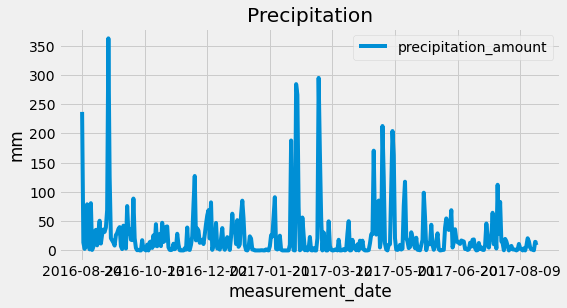

In [68]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = precipitation_df.plot(figsize=(8,4))
ax.set_title("Precipitation")
ax.set_ylabel('mm')
plt.show()

In [61]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation_amount
count,365.000000
mean,24.760274
std,45.113719
min,0.000000
25%,1.400000
50%,10.100000
75%,27.500000
max,362.700000


# Exploratory Station Analysis

In [63]:
# Design a query to calculate the total number stations in the dataset
locations = session.query(Measurement).group_by(Measurement.station).count()
print("{} stations.".format(locations))

9 stations.


In [69]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
sel = [Measurement.station, 
       func.count(Measurement.date)]
active_stations = session.query(*sel).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.date).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [70]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [Measurement.station,
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
station_temp_summary = session.query(*sel).\
        filter(Measurement.station == 'USC00519281').\
        group_by(Measurement.station)
for station in station_temp_summary:
    print(station)

('USC00519281', 12.2, 29.4, 22.03582251082252)


In [77]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and 
sel = [Measurement.date, 
       Measurement.tobs]
station_temps = session.query(*sel).\
        filter(func.strftime(Measurement.date) >= start_date, Measurement.station == 'USC00519281').\
        group_by(Measurement.date).\
        order_by(Measurement.date).all()
station_temps_df = pd.DataFrame(station_temps, columns=['Measurement Date', 'Temperature'])
station_temps_df.head(12)





,Measurement Date,Temperature
0,2016-08-24,25.0
1,2016-08-25,26.7
2,2016-08-26,26.7
3,2016-08-27,23.9
4,2016-08-28,22.8
5,2016-08-29,25.6
6,2016-08-30,25.0
7,2016-08-31,25.6
8,2016-09-01,26.7
9,2016-09-02,26.7


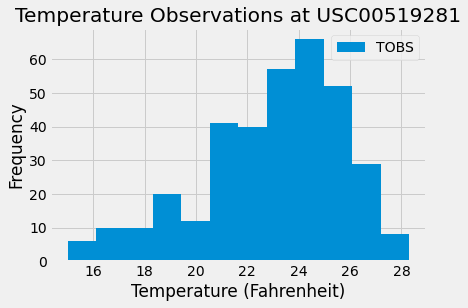

In [79]:
#plot the results as a histogram
plt.hist(station_temps_df['Temperature'],bins=12, density=False, label="TOBS")
plt.xlabel("Temperature (Fahrenheit)")
plt.ylabel("Frequency")
plt.legend()
plt.title("Temperature Observations at USC00519281")
plt.figsize=(10,7)
plt.savefig('Annual_Temps_USC00519281.png',bbox_inches='tight')
plt.show()


# Close session

In [80]:
# Close Session
session.close()